# Data Preparation

In [9]:
# Load and setup Django project 

%reload_ext autoreload
%autoreload 2

import os
import sys

os.chdir(os.path.dirname(os.getcwd()))
sys.path.insert(0, os.getcwd())
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "config.settings.development")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup()
import pandas as pd

In [10]:
# Export the data from the News model to CSV 

import csv
from django.conf import settings
from data_labeling.models import News


DATA_DIR = settings.BASE_DIR / 'notebooks/data'
csv_filename = f'{DATA_DIR}/crypto-news.csv'

with open(csv_filename, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['text', 'label'])

    for news in News.objects.all():
        writer.writerow([news.title, news.sentiment])

print(f'Saved to data/{os.path.basename(csv_filename)}.')

Saved to data/crypto-news.csv.


In [11]:
import re
import html
import pandas as pd


df = pd.read_csv(csv_filename)
df = df.dropna()

def cleanup_text(x):
    remove_text = [
        'First Mover Americas:',
        'First Mover Asia:',
    ]
    x = html.unescape(x.strip())
    x = re.sub('<.*?>', '', x)
    x = re.sub('\s+', ' ', x)
    x = x.replace(u'\u200b', '')
    for text in remove_text:
        x = x.replace(text, '')
    return x.strip()

df['text'] = df['text'].apply(cleanup_text)

df

,text,label
0,Coinbase: Ether Selling Pressure Should Be Fai...,neutral
1,BUSD Stablecoin Inches Toward $1 Peg After Bin...,positive
2,"Sam Bankman-Fried, Caroline Ellison, and Other...",negative
3,NFT Marketplace Blur's Token Reaches $500M Tra...,positive
4,Bitcoin BTC Price Rebounds Above $22K After Te...,neutral
...,...,...
1106,Most blockchain advocates haven‘t even used Bi...,neutral
1107,"What is QuickSwap, and how does it work?. Swap...",neutral
1108,Binance custody partner clarifies Singapore li...,neutral
1109,United States CBDC would ‘crowd out’ crypto ec...,neutral


Plot the frequency of the classes:

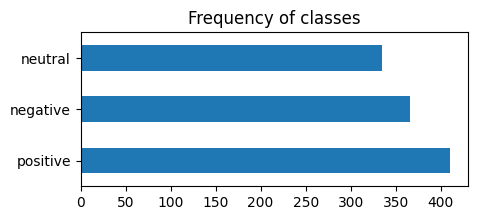

In [12]:
import matplotlib.pyplot as plt 

df['label'].value_counts().plot.barh(figsize=(5,2))
plt.title('Frequency of classes')
plt.show()

Plot the number of words per sample data:

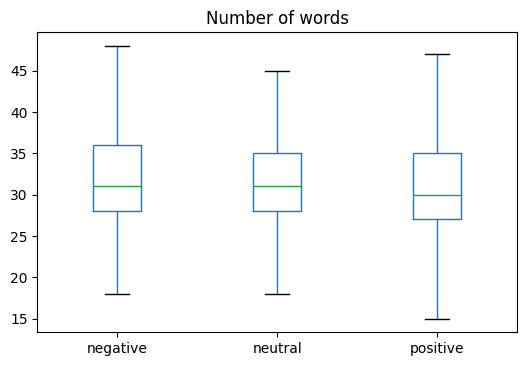

In [13]:
df['num_words'] = df['text'].str.split().apply(len)
df.boxplot('num_words', by='label', grid=False, showfliers=False, figsize=(6,4))
plt.title('Number of words')
plt.suptitle('')
plt.xlabel('')
plt.show()

df = df.drop('num_words', axis=1)

In [14]:
# Make balanced dataset
df_pos = df[df['label'] == 'positive'].sample(350)
df_neg = df[df['label'] == 'negative'].sample(350)
df_net = df[df['label'] == 'neutral']


def train_test_split(df, frac=1.0):
    a = df.sample(frac=frac)
    b = df.drop(a.index)
    return a, b


df_train_pos, df_pos = train_test_split(df_pos, frac=0.5)
df_train_neg, df_neg = train_test_split(df_neg, frac=0.5)
df_train_net, df_net = train_test_split(df_net, frac=0.5)

df_val_pos, df_test_pos = train_test_split(df_pos, frac=0.5)
df_val_neg, df_test_neg = train_test_split(df_neg, frac=0.5)
df_val_net, df_test_net = train_test_split(df_net, frac=0.5)

df_train = pd.concat([df_train_pos, df_train_neg, df_train_net]).sample(frac=1.0)
df_val = pd.concat([df_val_pos, df_val_neg, df_val_net]).sample(frac=1.0)
df_test = pd.concat([df_test_pos, df_test_neg, df_test_net]).sample(frac=1.0)

df_train.to_csv(f'{DATA_DIR}/crypto-news-train.csv', index=False)
df_val.to_csv(f'{DATA_DIR}/crypto-news-val.csv', index=False)
df_test.to_csv(f'{DATA_DIR}/crypto-news-test.csv', index=False)

Convert to HuggingFace Dataset:

In [2]:
from datasets import load_dataset, Features, Value, ClassLabel


data_files = {
    'train': 'data/crypto-news-train.csv',
    'validation': 'data/crypto-news-val.csv',
    'test': 'data/crypto-news-test.csv',
}

class_names = ['negative', 'neutral', 'positive']
features = Features({
    'text': Value('string'), 
    'label': ClassLabel(names=class_names)
})

dataset = load_dataset('csv', data_files=data_files, features=features)
dataset

Found cached dataset csv (/Users/nash/.cache/huggingface/datasets/csv/default-a7bf34c4be4e567e/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 518
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 257
    })
})

Push to the Hub:

In [3]:
from huggingface_hub import notebook_login 

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/nash/.cache/huggingface/token
Login successful


In [4]:
dataset.push_to_hub('crypto-news-headlines')

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split validation to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]